In [5]:
import cv2
import imutils
import numpy as np
import copy
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
# Load Yolo
# loading trained network
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
classes = []  # classes are categories that we are detecting
with open("coco.names", "r") as f:  # loading classes
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

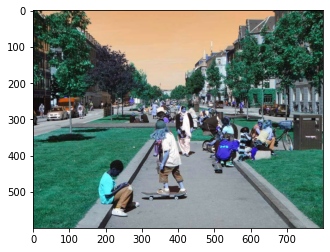

In [9]:
# Loading image
img_org = cv2.imread("test-street-marked-01.jpg")
img_org = imutils.resize(img_org, width=800)

img = copy.deepcopy(img_org)
height, width, channels = img.shape

plt.imshow(img)


In [10]:
# Detecting objects
blob = cv2.dnn.blobFromImage(
    img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers)


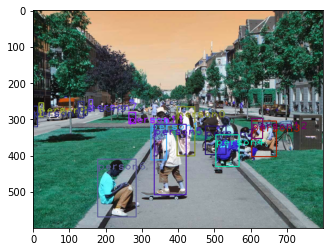

In [11]:

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
points = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5 and classes[class_id] == 'person':
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # lowest point of the box (on the ground)
            points.append([center_x, int(center_y+h/2)])
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label+str(i), (x, y + 30), font, 2, color, 2)

plt.imshow(img)


In [12]:
# finding markers
points = np.asarray(points, dtype=np.float32)
points = np.array([points])
markers = tools.find_markers(img_org)
corners, img_org = tools.sort_markers(markers, img_org)

plt.imshow(img_org)

NameError: name 'tools' is not defined

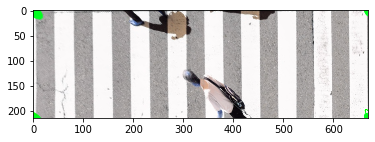

In [60]:
# perspective correction
warped, M = tools.four_point_transform(img_org, corners)

plt.imshow(warped)


 Homography matrix


array([[ 1.43513208e+00,  2.81833334e+00,  4.40745622e-01],
       [-5.02658355e-01,  2.95431886e+00,  4.02861710e+02],
       [ 2.83048053e-04,  1.59987071e-03,  1.00000000e+00]])

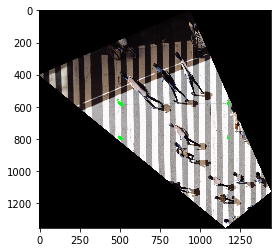

In [61]:
# padding correction
# reference: https://github.com/alkasm/padded-transformations
top_view, M = tools.warpPerspectivePadded(img_org, warped, M)
plt.imshow(top_view)
print('\n Homography matrix')
M

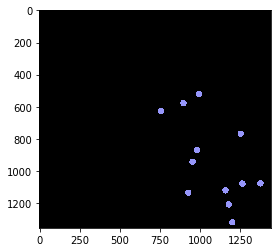

In [62]:
# Converting detected coordinates to transformed image
pointsOut = cv2.perspectiveTransform(points, M)
pointsOut = np.asarray(pointsOut, dtype=np.int32)
pointsOut = pointsOut.tolist()[0]

# Creating blank image
height, width = top_view.shape[:2]
map = np.zeros((height, width, 3), np.uint8)
map[:, :] = (0, 0, 0)
for i in pointsOut:
    cv2.circle(map, (i[0],i[1]), 20, (150, 150, 250), -1)

plt.imshow(map)